# Imports

In [1]:
import os, re, json, hashlib
from datetime import datetime
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Configuration

In [2]:
DATA_PATH = "/Users/ashwin/Applications/Master/air-lead-enrichment/data/messy_leads.csv"

In [3]:
df = pd.read_csv(DATA_PATH)

In [4]:
print({"rows": len(df), "cols": len(df.columns)})
display(df.head(20))


{'rows': 100, 'cols': 8}


,Name,Email,Title,Company,Phone,Source,Country,Created At
0,Alice Anderson,alice.anderson@company.com,Product Lead,GlobalTech,(123) 456-7890,Referral,United States,19-Mar-2025
1,Alice Jones,alice.jones@business.co,CEO,Air Inc,+1 800 555 1212,Website Visitor,US,2025-04-01
2,carol,valid@example.com,VP Mktg,example corp,call me,LinkedIn,CA,NaN
3,Jack Brown,jack.brown@business.co,NaN,example corp,5551212,LinkedIn,US,2024-10-30
4,Carol Martinez,carol.martinez@business.co,Marketing Manager,COMPANY,123-456-7890,LinkedIn,CA,2025-01-11
5,Alice Lee,alice.lee@startup.io,Sr. Eng,example corp,call me,Website Visitor,France,12-May-2025
6,Ivy Chen,ivy.chen@gmail.com,Marketing Manager,COMPANY,call me,LinkedIn,France,05/07/2025
7,Carol Chen,carol.chen@gmail.com,CTO,Air Inc,call me,Website Visitor,UK,2025-03-09
8,BOB JONES,bob.jones@Example.Com,product lead,Air.Inc,(123) 456-7890,Referral,NaN,12 days ago
9,,missing-at-symbol.com,VP Mktg,NaN,+1 800 555 1212,linkedin,usa,3 days ago


In [5]:
df.dtypes

Name          object
Email         object
Title         object
Company       object
Phone         object
Source        object
Country       object
Created At    object
dtype: object

So we have - Name, Email, Title, Company, Phone, Source, Country and Created at with all Object types. Lets analyze these columns in more detail. Lets see how many missing columns each have

In [10]:
print(f"There are {df.nunique()} unique elements")
print()
print(f"There are {df.isna().sum()} missing elements")
print()

There are Name          60
Email         92
Title         14
Company       11
Phone          5
Source         6
Country        9
Created At    93
dtype: int64 unique elements

There are Name           1
Email          0
Title          4
Company        9
Phone         16
Source         0
Country       14
Created At     2
dtype: int64 missing elements



In [11]:
col_overview = pd.DataFrame({
    "dtype": df.dtypes,
    "n_unique": df.nunique(),
    "n_missing": df.isna().sum(),
    "%_missing": (df.isna().mean() * 100).round(2),
}).sort_values("%_missing", ascending=False)
display(col_overview.reset_index().rename(columns={"index": "column"}))

,column,dtype,n_unique,n_missing,%_missing
0,Phone,object,5,16,16.0
1,Country,object,9,14,14.0
2,Company,object,11,9,9.0
3,Title,object,14,4,4.0
4,Created At,object,93,2,2.0
5,Name,object,60,1,1.0
6,Email,object,92,0,0.0
7,Source,object,6,0,0.0


In [12]:
df['Email'].value_counts()

Email
alice.chen@startup.io      3
grace.johnson@gmail.com    2
jack.brown@company.com     2
bob.jones@Example.Com      2
missing-at-symbol.com      2
                          ..
jack.wilson@air.inc        1
henry.brown@company.com    1
bob.martinez@startup.io    1
david.smith@business.co    1
henry.smith@business.co    1
Name: count, Length: 92, dtype: int64

On the surface we can see some emails have inconsistent formatting in terms of casing, good thing is there are no missing emails. We could probably use the domain from the email to fill Null Company Names

In [15]:
email_re = re.compile(r"^[A-Za-z0-9._%+\-]+@[A-Za-z0-9.\-]+\.[A-Za-z]{2,}$")

def is_valid_email(x: str) -> bool:
    if not isinstance(x, str): return False
    x = x.strip()
    return bool(x) and bool(email_re.match(x))

def normalize_phone(x: str) -> str:
    if not isinstance(x, str): return ""
    digits = re.sub(r"\D", "", x)
    if len(digits) == 11 and digits.startswith("1"):
        digits = digits[1:]
    if len(digits) == 10:
        return f"+1{digits}"
    if 11 <= len(digits) <= 15:
        return "+" + digits
    return ""

def try_parse_date(x):
    if pd.isna(x): return pd.NaT
    for fmt in ("%Y-%m-%d", "%m/%d/%Y", "%d/%m/%Y", "%Y/%m/%d"):
        try: return pd.to_datetime(datetime.strptime(str(x).strip(), fmt))
        except Exception: pass
    return pd.to_datetime(x, errors="coerce")

def titlecase_name(x: str) -> str:
    if not isinstance(x, str): return ""
    return " ".join(w.capitalize() for w in x.strip().split())


I want to design a backend service which will take a CSV upload and return a cleaned version of it. For this to work, I want to introduce flexibility in column names, so I want to standardize them.

In [13]:
lower_cols = {c.lower(): c for c in df.columns}
col_map = {
    "first_name": next((lower_cols[c] for c in lower_cols if "first" in c and "name" in c), None),
    "last_name": next((lower_cols[c] for c in lower_cols if "last" in c and "name" in c), None),
    "full_name": next((lower_cols[c] for c in lower_cols if c in ("name","full_name","fullname","contact name")), None),
    "email":     next((lower_cols[c] for c in lower_cols if "email" in c), None),
    "phone":     next((lower_cols[c] for c in lower_cols if "phone" in c or "mobile" in c), None),
    "title":     next((lower_cols[c] for c in lower_cols if "title" in c or "role" in c or "position" in c), None),
    "company":   next((lower_cols[c] for c in lower_cols if "company" in c or "org" in c), None),
    "country":   next((lower_cols[c] for c in lower_cols if "country" in c), None),
    "created_at":next((lower_cols[c] for c in lower_cols if "create" in c or "date" in c or "timestamp" in c), None),
    "source":    next((lower_cols[c] for c in lower_cols if "source" in c or "channel" in c), None),
}
print("Column map:", col_map)

Column map: {'first_name': None, 'last_name': None, 'full_name': 'Name', 'email': 'Email', 'phone': 'Phone', 'title': 'Title', 'company': 'Company', 'country': 'Country', 'created_at': 'Created At', 'source': 'Source'}


Lets clean the data which will inform us what functions to use in the backend service. Lets create a 1:1 mapping with the working dataframe and create a new frame out of it with cleaned rows.

The following block standardizes names across messy inputs, safeguards against common edge cases, and produces fields that your enrichment, scoring, dedup, and Salesforce ingestion can trust.

In [16]:
working = pd.DataFrame(index=df.index)

if col_map["full_name"]:
    working["full_name_raw"] = df[col_map["full_name"]].astype(str)
    split_names = working["full_name_raw"].str.strip().str.split(r"\s+", n=1, expand=True)
    working["first_name_norm"] = split_names[0].apply(titlecase_name)
    working["last_name_norm"]  = (split_names[1].fillna("").apply(titlecase_name)
                                  if split_names.shape[1] > 1 else "")
else:
    if col_map["first_name"]:
        working["first_name_norm"] = df[col_map["first_name"]].astype(str).apply(titlecase_name)
    if col_map["last_name"]:
        working["last_name_norm"]  = df[col_map["last_name"]].astype(str).apply(titlecase_name)



Lets Clean and validate emails: cast to string, trim and lowercase into `email_lower`, then flag `email_valid` via regex (or set `False` if no email column).

In [17]:
if col_map["email"]:
    working["email_raw"]   = df[col_map["email"]].astype(str).str.strip()
    working["email_lower"] = working["email_raw"].str.lower().str.strip()
    working["email_valid"] = working["email_lower"].apply(is_valid_email)
else:
    working["email_valid"] = False


Now lets Normalize key fields: copy raw `phone`, `title`, `company`; compute  `phone_norm` via `normalize_phone`, and trim + Title-Case into `title_norm` and `company_norm`.


In [25]:
if col_map["phone"]:
    working["phone_raw"]  = df[col_map["phone"]].astype(str)
    working["phone_norm"] = working["phone_raw"].apply(normalize_phone)

if col_map["title"]:
    working["title_raw"]  = df[col_map["title"]].astype(str)
    working["title_norm"] = working["title_raw"].str.strip().str.title()

if col_map["company"]:
    working["company_raw"]  = df[col_map["company"]].astype(str)
    working["company_norm"] = working["company_raw"].str.strip().str.title()


Lets canonicalize some of the fields in the countries and map them to cleaner names. 

In [26]:
COMMON_COUNTRIES = {
    "usa": "United States", "us": "United States", "u.s.": "United States",
    "u.s.a": "United States", "united states": "United States",
    "uk": "United Kingdom", "u.k.": "United Kingdom", "england": "United Kingdom",
    "gb": "United Kingdom", "great britain": "United Kingdom",
    "de": "Germany", "ger": "Germany", "d": "Germany",
    "uae": "United Arab Emirates", "u.a.e": "United Arab Emirates",
    "korea": "South Korea", "south korea": "South Korea",
    "republic of korea": "South Korea",
    "vietnam": "Vietnam", "viet nam": "Vietnam",
    "india": "India", "ind": "India",
    "australia": "Australia", "austria": "Austria",
    "nederland": "Netherlands", "netherlands": "Netherlands",
}
if col_map["country"]:
    working["country_raw"]  = df[col_map["country"]].astype(str)
    working["country_norm"] = (working["country_raw"].str.strip().str.lower()
                               .map(COMMON_COUNTRIES)
                               .fillna(working["country_raw"].str.strip().str.title()))



Normalizing dates

In [20]:
if col_map["created_at"]:
    working["created_at_raw"]    = df[col_map["created_at"]]
    working["created_at_parsed"] = working["created_at_raw"].apply(try_parse_date)


In [27]:
if col_map["source"]:
    working["source_raw"]  = df[col_map["source"]].astype(str)
    working["source_norm"] = working["source_raw"].str.strip().str.title()

In [28]:
metrics = {}
if "email_valid" in working:
    metrics["%_valid_emails"] = round(working["email_valid"].mean() * 100, 2)

if "phone_norm" in working:
    phone_nonempty = (working["phone_norm"].astype(str).str.len() > 0).mean()
    metrics["%_normalized_phones"] = round(phone_nonempty * 100, 2)

if "created_at_parsed" in working:
    metrics["%_parsed_dates"] = round((~working["created_at_parsed"].isna()).mean() * 100, 2)

if "country_norm" in working:
    metrics["n_unique_countries"] = working["country_norm"].nunique()

print("Key metrics:", metrics)


Key metrics: {'%_valid_emails': np.float64(95.0), '%_normalized_phones': np.float64(48.0), '%_parsed_dates': np.float64(92.0), 'n_unique_countries': 8}


### Data quality story: where we have signal, where we don’t, and what to do next

Our quick health check surfaces a clear pattern:

* **Email is our strongest identifier** — **95%** pass regex validation.
  *Implication:* we can lean on email for dedupe, outreach, and enrichment keys. It’s safe to make “valid email **or** normalized phone” the minimum viability rule for a keep.

* **Phone is the weak link** — only **48%** normalize cleanly to E.164-like.
  *Why this matters:* phone-dependent workflows (dialers, SMS, match-to-accounts via switchboards) will underperform without additional normalization.
  *Action:* keep our current heuristic for speed, but plan a `phonenumbers` upgrade and country-aware parsing. Also track “geo mismatch” (e.g., `+1` with non-US country) as a quality warning.

* **Timestamps are reliable** — **92%** parse to ISO dates.
  *Implication:* time-based funnel analysis (cohorting, lead aging, SLA) is trustworthy out of the gate.
  *Action:* enforce ISO on ingest and flag the remaining 8% for source-specific fixes (often a locale or format drift).

* **Geographic diversity is modest** — **8 unique countries**.
  *Implication:* enough variation to justify canonical country mapping and country-specific routing (AE territory rules, SLA by region), but not so diverse that the mapping table becomes heavy.

**Policy decisions informed by this:**

1. **Drop rule:** keep a lead if it has **valid email OR normalized phone**; otherwise mark as dropped with reason code.
2. **Scoring:** boost leads with valid emails; give smaller credit for normalized phone; add country/source boosts; penalize missing company.
3. **Ops focus:** prioritize phone normalization improvements (and geo-consistency checks) over email quality, which is already high.
4. **Observability:** log per-field failure rates (phone normalization, date parse, country map) and surface them in a weekly data quality dashboard.


In [29]:
if "source_norm" in working:
    display(working["source_norm"].value_counts().head(10).rename_axis("source").reset_index(name="count"))

if "title_norm" in working:
    display(working["title_norm"].value_counts().head(15).rename_axis("title").reset_index(name="count"))


,source,count
0,Website Visitor,27
1,Referral,24
2,Linkedin,18
3,Product Signup,17
4,Event,14


,title,count
0,Head Of Sales,13
1,Product Lead,11
2,Sr. Engineer,11
3,Vp Mktg,10
4,Ceo,9
5,Cto,8
6,Data Analyst,8
7,Marketing Manager,6
8,Designer,6
9,Software Engineer,6


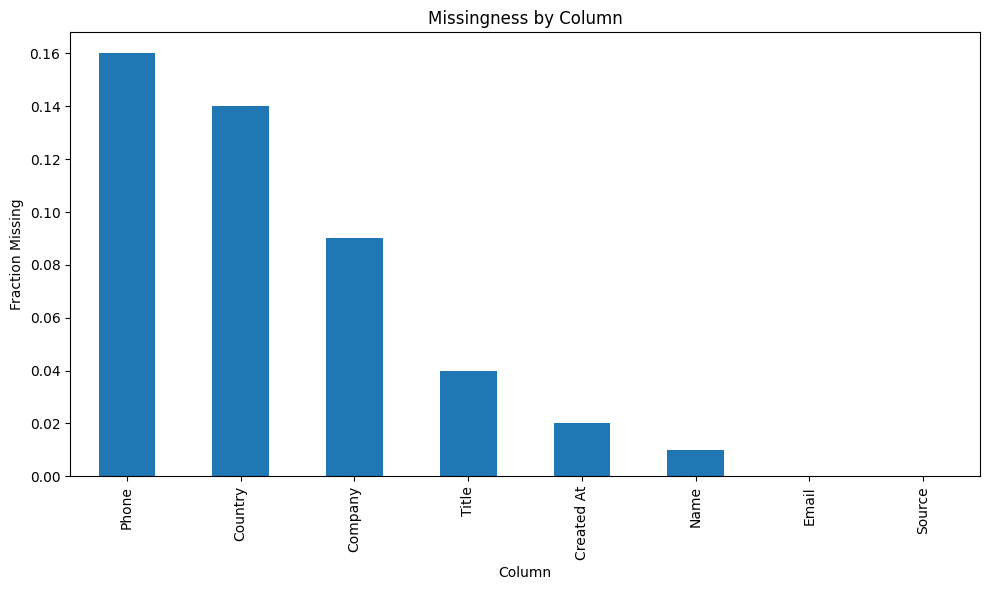

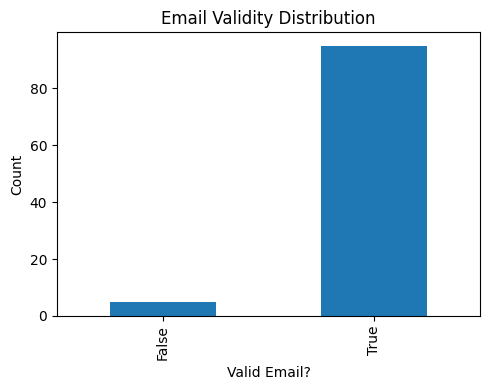

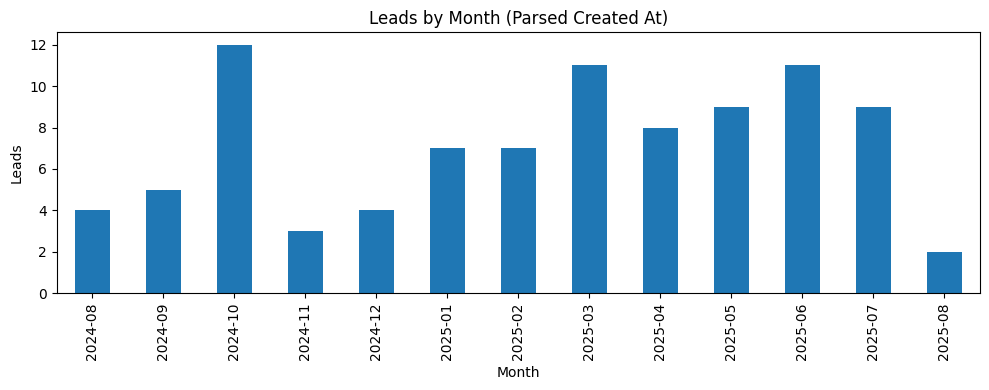

Saved: EDA_SUMMARY.md, eda_working_frame.csv, clean_for_salesforce.csv


In [30]:
missing_rates = df.isna().mean().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
missing_rates.plot(kind="bar")
plt.title("Missingness by Column"); plt.xlabel("Column"); plt.ylabel("Fraction Missing")
plt.tight_layout(); plt.show()

if "email_valid" in working:
    plt.figure(figsize=(5, 4))
    working["email_valid"].value_counts(dropna=False).sort_index().plot(kind="bar")
    plt.title("Email Validity Distribution"); plt.xlabel("Valid Email?"); plt.ylabel("Count")
    plt.tight_layout(); plt.show()

if "created_at_parsed" in working and working["created_at_parsed"].notna().any():
    plt.figure(figsize=(10, 4))
    working["created_at_parsed"].dropna().dt.to_period("M").value_counts().sort_index().plot(kind="bar")
    plt.title("Leads by Month (Parsed Created At)"); plt.xlabel("Month"); plt.ylabel("Leads")
    plt.tight_layout(); plt.show()

working.to_csv("eda_working_frame.csv", index=False)

summary_lines = []
summary_lines.append(f"Rows: {len(df)}, Cols: {len(df.columns)}")
for k, v in metrics.items():
    summary_lines.append(f"{k}: {v}")
summary_lines.append("Column missingness (top 10):")
summary_lines += [f"- {c}: {round(m*100,2)}%" for c, m in missing_rates.head(10).items()]
eda_md = "# EDA Summary\n\n" + "\n".join(f"- {line}" for line in summary_lines)
with open("EDA_SUMMARY.md", "w") as f:
    f.write(eda_md)

clean_cols = []
for c in ["first_name_norm","last_name_norm","email_lower","phone_norm","title_norm","company_norm","country_norm","created_at_parsed","source_norm"]:
    if c in working.columns: clean_cols.append(c)
clean_df = working[clean_cols].copy()
rename_map = {
    "first_name_norm": "FirstName",
    "last_name_norm":  "LastName",
    "email_lower":     "Email",
    "phone_norm":      "Phone",
    "title_norm":      "Title",
    "company_norm":    "Company",
    "country_norm":    "Country",
    "created_at_parsed":"CreatedAt",
    "source_norm":     "LeadSource",
}
clean_df.rename(columns=rename_map).to_csv("clean_for_salesforce.csv", index=False)
print("Saved: EDA_SUMMARY.md, eda_working_frame.csv, clean_for_salesforce.csv")
